In [6]:
import networkx as nx
import random
import shlex
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pyvis.network import Network
import utils, analyze_dataset
import pickle
import arff
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You can choose to extract from DBPedia graph directly or load the preproocessed files. 

1. Directly Extract from DBPedia Files:
You will need three files: The ontology graph (skos.ttl), labels (articles.ttl). These two files are under "Wikipedia Article Categories and categories metadata". You can get the abstracts (short-abstracts_lang=en.ttl) under "Shortened abstracts from Wikipedia articles". These files can be acquired from https://databus.dbpedia.org/dbpedia/collections


In [18]:
# set the paths to the required files

PATH_TO_GRAPH = '/.../categories_lang=en_skos.ttl'
PATH_TO_LABELS = '/.../categories_lang=en_articles.ttl'
PATH_TO_ABSTRACTS = '/.../short-abstracts_lang=en.ttl'

print ("loading DBPedia graph..")
DG = utils.load_graph(PATH_TO_GRAPH)
print ("loading DBPedia labels..")
mapping = utils.load_labels(PATH_TO_LABELS)
print ("loading DBPedia abstracts..")
all_abstracts = utils.load_abstracts(PATH_TO_ABSTRACTS)
utils.compute_stats(DG, mapping, all_abstracts)

2. Load the preprocessed files:
The version of the preprocessed graphs from DBPedia is the 2021-09 snapshot (https://databus.dbpedia.org/dbpedia/collections/dbpedia-snapshot-2021-09/). 

In [14]:
with open('mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

with open('all_abstracts.pkl', 'rb') as f:
    all_abstracts = pickle.load(f)

DG = nx.read_gpickle("DBPedia-2021.gpickle")

analyze_subgraph function will allow you to extract the desired subgraph from the DBPedia ontology based on the input: starting_node, max_hop, and min_data to control contextual, distributional, and structural aspects of your datasets. The code will produce basic stats for the subgraph: Node count, data count, data distribution, degree distribution, and coverage.

You can export the subgraph by turning "export" to True. The code will create a folder and export all data into the folder. 

Node Count: 587
Data Count: 22735


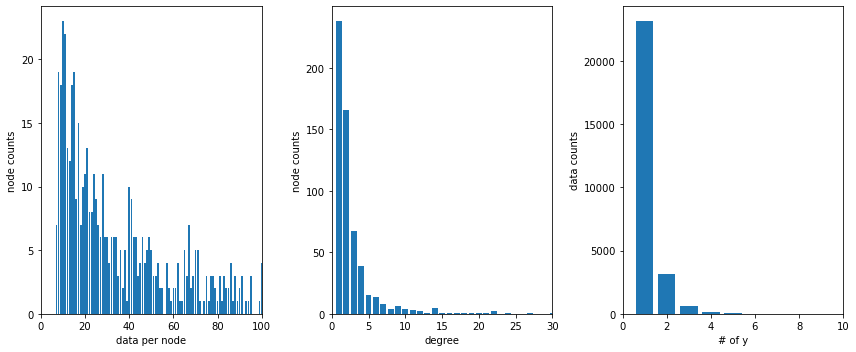

In [49]:
starting_node = "Engineering"
eng_sub = utils.analyze_subgraph(DG,mapping, all_abstracts, starting_node, max_hop = 3, min_data = 6, export = False)

Node Count: 395
Data Count: 8333


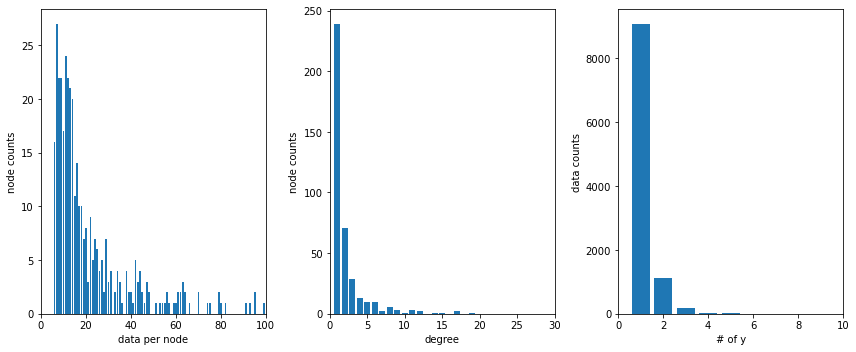

In [47]:
starting_node = "Comedy"
utils.analyze_subgraph(starting_node, min_data = 5,  export = False)

Node Count: 958
Data Count: 61974


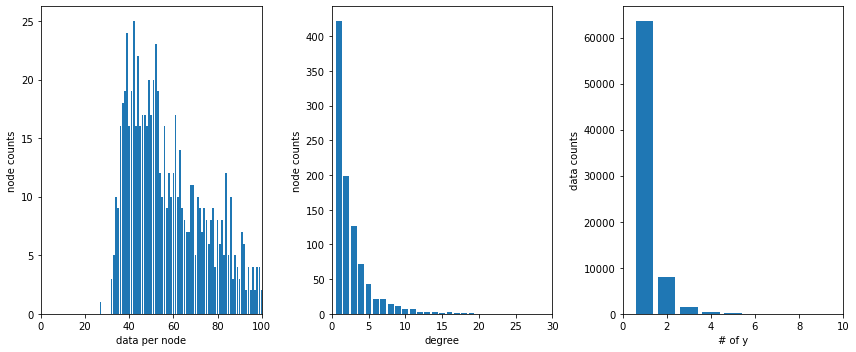

In [48]:
starting_node = "Law"
utils.analyze_subgraph(starting_node, max_hop = 7, min_data = 30, export = True)

Node Count: 147
Data Count: 15310


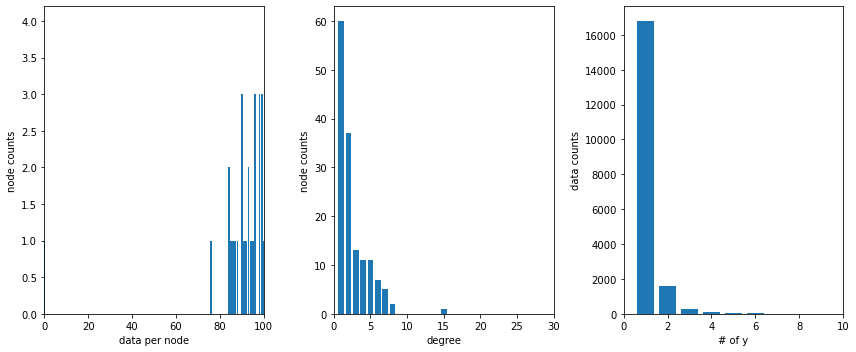

In [65]:
starting_node = "Main_topic_classifications"
utils.analyze_subgraph(starting_node, max_hop = 5, min_data = 70, export = True)

In [ ]:
# codes to save the processed data.

with open('mapping.pkl', 'wb') as f:
    pickle.dump(mapping,f)

with open('all_abstracts.pkl', 'wb') as f:
    pickle.dump(all_abstracts,f)

nx.write_gpickle(DG, "DBPedia-2021.gpickle")

In [9]:
# function to convert extracted data to arff format
def covert_to_arff(folderpath, starting_node, val_ratio = 0.1, test_ratio = 0.1):
    
    
    G = nx.read_edgelist(folderpath + 'graph.edgelist')

    data = pickle.load(open(folderpath + 'data.pkl', 'rb'))
    with open(folderpath + 'graph.edgelist', 'r') as f:
        graph = f.readlines()

    graph = ['/'.join(line.strip().replace("'", '').replace('/', '').replace('@', '').split(' ')) for line in graph]
    hierarchy = 'root/%s,'%starting_node+','.join(graph)

    arff_data_train = {
        'relation': folderpath,
        'attributes':[('bert%d'%x, 'numeric') for x in range(384)] + [('class', 'hierarchical '+hierarchy)],
        'data':[]
    }
    arff_data_val = {
        'relation': folderpath,
        'attributes':[('bert%d'%x, 'numeric') for x in range(384)] + [('class', 'hierarchical '+hierarchy)],
        'data':[]
    }
    arff_data_test = {
        'relation': folderpath,
        'attributes':[('bert%d'%x, 'numeric') for x in range(384)] + [('class', 'hierarchical '+hierarchy)],
        'data':[]
    }

    for d in data:
        rand = random.random()
        y = [x.replace("'", '').replace('/', '').replace('@', '') for x in data[d]['y']]
        if rand <test_ratio:
            arff_data_test['data'].append(list(data[d]['bert_abstract']) + ['@'.join(y)])
        elif rand < val_ratio+test_ratio:
            arff_data_val['data'].append(list(data[d]['bert_abstract']) + ['@'.join(y)])
        else:
            arff_data_train['data'].append(list(data[d]['bert_abstract']) + ['@'.join(y)])

    arff_test = arff.dumps(arff_data_test)
    arff_val = arff.dumps(arff_data_val)
    arff_train = arff.dumps(arff_data_train)
    
    with open(folderpath + '%s.test.arff'%starting_node, 'w') as f:
    	f.write(arff_test)
    with open(folderpath + '%s.valid.arff'%starting_node, 'w') as f:
    	f.write(arff_val)
    with open(folderpath + '%s.train.arff'%starting_node, 'w') as f:
    	f.write(arff_train)

In [10]:
# folderpath: the path to the folder with the extracted files
# starting_node: the starting node of this graph
# val_ratio: how much data do you want to split into validation set
# test_ratio: how much data do you want to split into test set

folderpath = 'Law/'

covert_to_arff(folderpath, starting_node = 'Law', val_ratio = 0.1, test_ratio = 0.1)